# Projet Final - GBM8770
## Multi-Scale Line Detector

Équipe #22
- Beaudry, Sophie (2140839)
- Lachapelle, Vincent (2206192)

In [1]:
# Vous permet de modifier vos fichiers importés et que les changements soient appliqués
# automatiquement, sans avoir à redémarer le notebook.
%load_ext autoreload  
%autoreload 2         

from copy import deepcopy
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import skimage.morphology as skmorph

%matplotlib inline
plt.rcParams["figure.figsize"] = (18, 8)  # Étend la taille des figures

In [2]:
from src.algo import MultiScaleLineDetector, dice, learn_threshold, naive_metrics
from src.dataset import Sample, load_dataset
from src.viz import plot_roc, show_diff


In [96]:
@dataclass
class PlotData:
    title: str
    image: np.ndarray

# Cette fonction sert à refactoriser la création des graphiques dans le jupyter notebook
def plot_images(data: list[PlotData]):
    fig, axes = plt.subplots(len(data), 1, figsize=(len(data) * 6 + 2, len(data) * 6))
    fig.tight_layout(h_pad=2.0)

    if len(data) != 1:
        for index, ax in enumerate(axes):
            ax.imshow(data[index].image, cmap='gray', vmin=0.0)
            ax.set_title(data[index].title)
            ax.set_xticks([])
            ax.set_yticks([])
    else:
        axes.imshow(data[0].image, cmap='gray', vmin=0.0)
        axes.set_title(data[0].title)
        axes.set_xticks([])
        axes.set_yticks([])

    return fig, axes

# 1. Implémentation de la MSLD

## 1.1. Préparatifs

Pour entraîner et valider l’algorithme, nous allons utiliser la base de données DRIVE fournie dans l'archive.


**Q1.** Complétez la fonction `load_dataset()` pour qu’elle charge et renvoie la base de données d’entraînement et de test (en incluant pour chaque échantillon: l’image, le label et le masque). Puis affichez l’image, le label et le masque de la première image de l’ensemble d’entraînement.

*(On notera cette image I1.)*

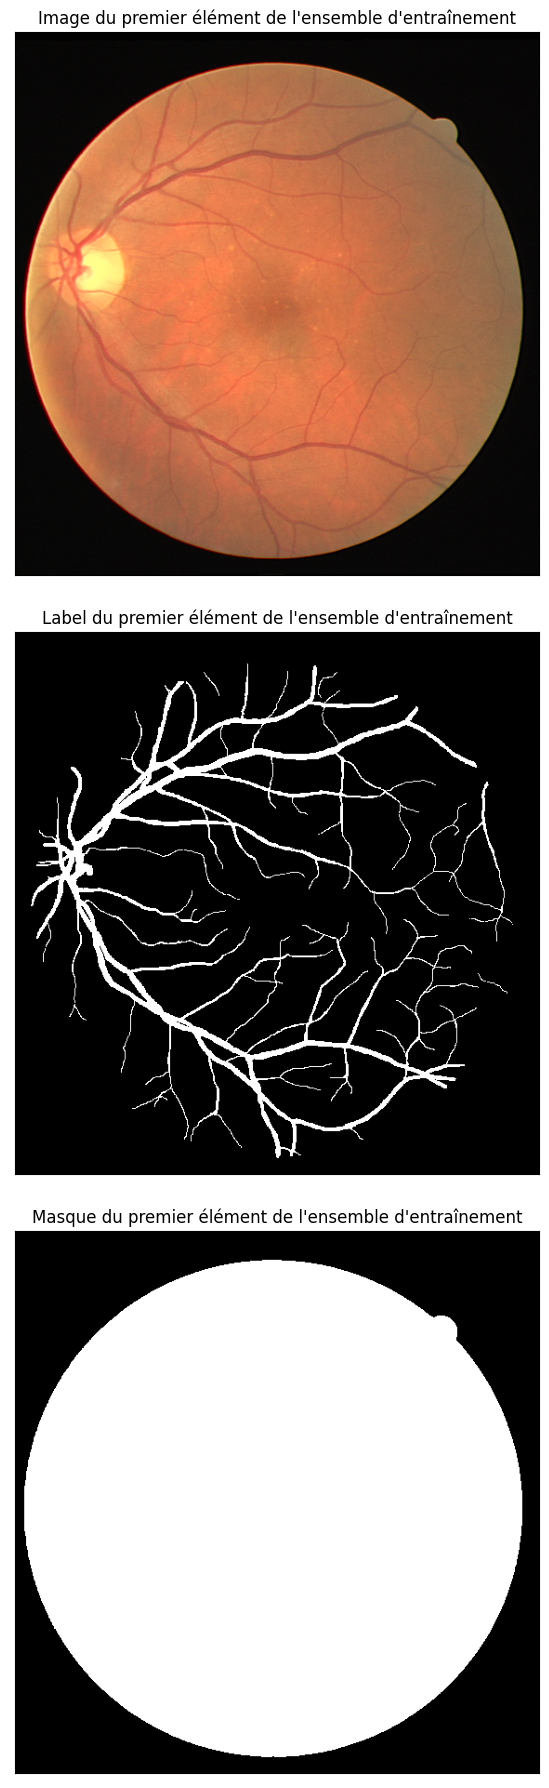

In [27]:
train, test = load_dataset()
I1 = train[0]

data = [PlotData(title="Image du premier élément de l'ensemble d'entraînement", image=I1.image),
        PlotData(title="Label du premier élément de l'ensemble d'entraînement", image=I1.label),
        PlotData(title="Masque du premier élément de l'ensemble d'entraînement", image=I1.mask)]

plot_images(data);


## 1.2. Basic Line Detector

Dans un soucis d’optimisation de l’implémentation, nous allons utiliser des convolutions dès que cela est possible. Particulièrement pour le calcul des moyennes d’intensités sur une fenêtre de taille `W` et le long des lignes de longueur `L`. De plus ces masques ne seront calculés qu’une seule fois, lors de l’instanciation de la classe MSLD.

**Q1.** Quel filtre de convolution permet le calcul de la valeur moyenne d’une fenêtre de taille `W` autour d'un pixel ? Complétez le constructeur de la classe `MultiScaleLineDetector` en définissant `avg_mask`.


Le filtre moyenneur permet le calcul de la valeur moyenne d'un pixel par une convolution. Le masque pour ce filtre est simplement créé en prenant une matrice de 1 de taille WxW, puis en la divisant par la somme de ces composantes.

**Q2.** On souhaite implémenter le BLD en utilisant des masques de convolution. Ces masques viendront sélectionner les pixels le long d'une ligne. Ils seront définis par leur longuer `L` et une série d'orientations. Expliquez comment construire les masques pour permettre le calcul de la valeur moyenne le long de lignes de taille `L` pour `num_orientations`. Complétez le constructeur de la classe `MultiScaleLineDetector` avec la définition de `line_detectors_masks`.

Pour construire les masques permettant le calcul de la valeur moyenne le long des lignes, nous commençons par créer le masque de la ligne horizontale. Ce masque est créé  en superposant des vecteurs de zéro ou de un de dimension (1, `L`). Nous tournons ensuite ce masque à l'aide d'une matrice de rotation standard en 2D. La variable `num_orientations` est utilisée afin de déterminer les angles à utiliser lors de la rotation. Cette technique suppose que toutes les valeurs de `L` sont impaires. Or, cette hypothèse est logique, puisque nous souhaitons créer des masques pour une convolution en deux dimensions. 

In [5]:
# Vous pouvez dès à présent instancier l'objet MSLD en remplaçant les hyper-paramètres W, L et num_orientations par
# leurs valeurs conseillées par l'article.
msld = MultiScaleLineDetector(W=15, L=[1, 3, 5, 7, 9, 11, 13, 15], num_orientations=12)

**Q3.** À l’aide de la section 3.1 de l’article, implémentez `basic_line_detector(grey_lvl, L)`.

**Q4.** Affichez la réponse du filtre appliqué à l’image I1 pour les longueurs L=1 et L=15. Comparez les deux et commentez.   

*Note: Attention le filtre BLD ne s’applique pas à tous les canaux de l’image. Relisez la section 3.1 de l’article pour plus d’informations...*

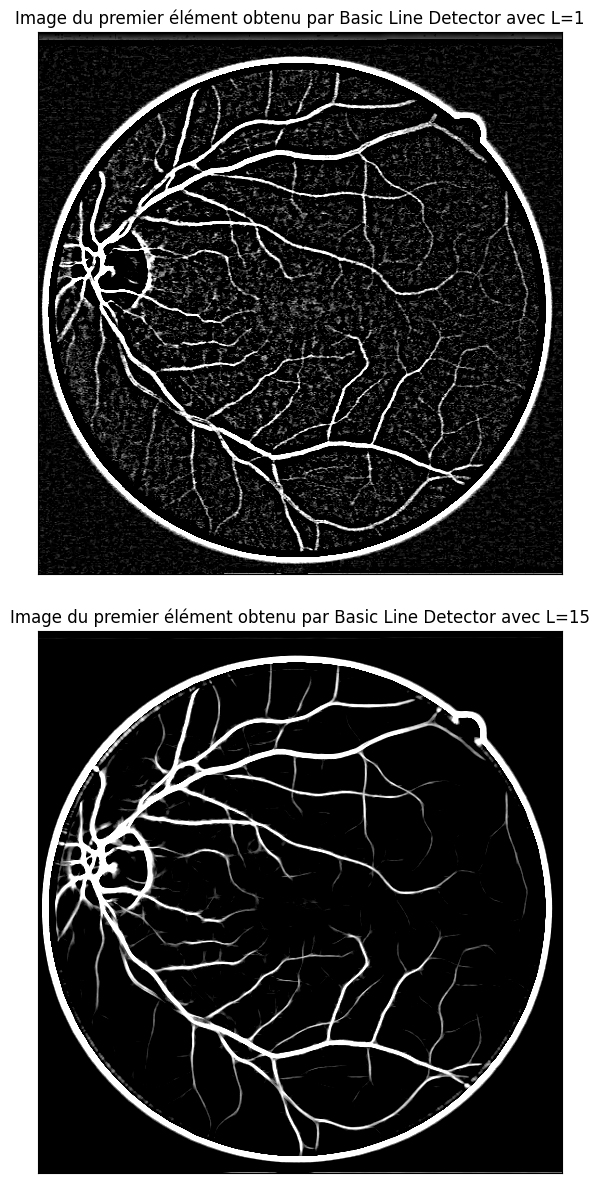

In [28]:
grey_lvl_I1 = 1 - I1.image[:, :, 1] # Nous inversons ici le canal vert

I1_bld_L1 = msld.basic_line_detector(grey_lvl_I1, L=1)
I1_bld_L15 = msld.basic_line_detector(grey_lvl_I1, L=15)

data = [PlotData(title="Image du premier élément obtenu par Basic Line Detector avec L=1", image=I1_bld_L1),
        PlotData(title="Image du premier élément obtenu par Basic Line Detector avec L=15", image=I1_bld_L15)]

plot_images(data);


Tel que discuté dans l'article, on remarque qu'avec une plus petite longueur de ligne L, l'image segmentée contient davantage de bruit et les contours des vaisseaux sont moins bien définis. Cependant, lorsque L augmente, on remarque que certains vaisseaux de la segmentation ont tendance à se fusionner ou à se scinder. Ce résultat est logique, car pour de petites lignes, le bruit impulsionnel n'est pas dilué par le masque utilisé. Ainsi, il apparaît comme un vaisseau dans notre segmentation. De plus, pour de grandes lignes, comme la région de pixels considérée est très grande et que l'algorithme segmente en fonction de l'intensité moyenne sur cette région, ce dernier peut segmenter à tord le fond entre deux vaisseaux très intenses ou des vaisseaux très minces sur un fond prononcé.

## 1.3. Multi-Scale Line Detector

**Q1.** À l’aide des sections 3.2 et 3.3 de l’article et de la méthode `self.basic_line_detector(grey_lvl, L)` déjà implémentée, implémentez `multi_scale_line_detector(image)`.

**Q2.** Affichez le résultat de l’algorithme appliqué à l’image I1. Comparez avec les réponses du filtre obtenues à la question 1.2.4, et commentez.

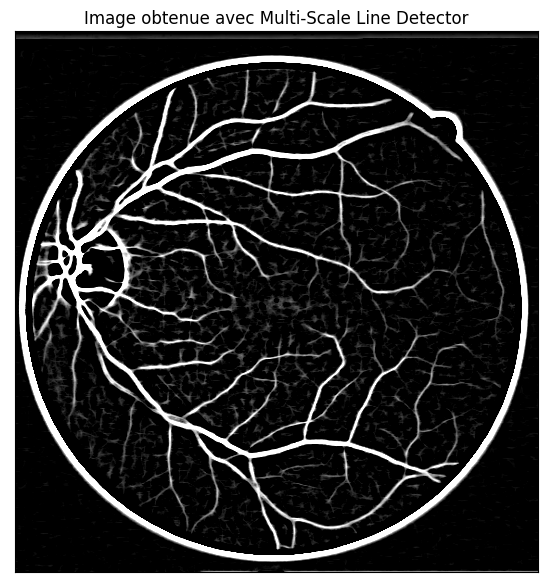

In [29]:
I1_msld = msld.multi_scale_line_detector(I1.image)

data = [PlotData(title="Image obtenue avec Multi-Scale Line Detector", image=I1_msld)]

plot_images(data);


La combinaison des différentes images obtenus par BLD permet d'obtenir une image finale qui contient encore beaucoup de bruit, mais dont la segmentation des vaisseaux est nettement plus clair et complète.

## 1.4. Apprentissage du seuil
 
Pour calculer le seuil donnant la meilleure précision sur l’ensemble d’entraînement efficacement, nous allons utiliser la courbe [ROC (Receiver Operating Characteristic)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). Cette courbe sera étudiée en détail dans la partie 2. Pour le moment, il vous faut juste savoir qu’elle associe à chaque seuil possible, le taux de faux positifs et le taux de vrais positifs si ce seuil était choisi.

**Q1.** Donnez la formule de la précision ACC (*accuracy* en anglais) en fonction du taux de faux positifs FPR, du taux de vrais positifs TPR, ainsi que du nombre de valeurs positives P, de valeurs négatives N et du nombre total de pixels S de la région d'intéret.   

Utilisez la syntaxe $\LaTeX$ pour formatter l'équation.

*(Vous pouvez vous aider des formules indiqués sur la page Wikipédia de la courbe ROC.)*

$ ACC = \frac{TPR \cdot P + (1 - FPR) \cdot N}{S} $

Pour vous faire gagner du temps, on vous donne la fonction `roc(msld, dataset)` qui calcule le TPR et le FPR associé à chaque seuil possible pour un dataset donné. Cette fonction utilise la fonction [`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) de `sklearn`. Assurez-vous que vous comprenez bien chaque ligne du code.

**Q2.** Pourquoi est-il si important de ne sélectionner uniquement les pixels qui appartiennent au masque? En particulier, comment évoluerait la précision si on sélectionnait finalement tous les pixels de l'image (sachant que hors du masque la prédiction du MSLD est toujours nulle)?

Si tous les pixels de l'image étaient considérés dans le calcul de la précision, alors le nombre de pixels de fond serait nettement supérieur au nombre de pixels représentant un vaisseau sanguin. Cette différence significative entre la taille des deux classes diminuerait la signification statistique de la métrique calculée, car un modèle qui classifierait simplement tous les pixels au groupe de fond obtiendrait tout de même une bonne précision globale.

**Q3.** À l’aide de la fonction `roc(msld, dataset)` et de la formule de la question 1 de cet exercice, complétez la fonction
`learn_threshold(msld, dataset)` qui identifie le seuil pour laquelle la précision est la plus élevée.


**Q4.** Utilisez cette fonction pour apprendre le seuil sur les images d’entraînement. Pour quelle raison faut il absolument conserver une partie des images (l’ensemble de test) et ne pas les utiliser pendant l’entraînement?

*N.B.: il n’est pas anormal d’obtenir un seuil différent de celui annoncé par les auteurs...*


In [8]:
threshold, accuracy = learn_threshold(msld, train)

print(f"Le meilleur seuil est {threshold:.4f}.")
print(f"La précision associée est de {accuracy:.4f}.")

Le meilleur seuil est 0.5645.
La précision associée est de 0.9249.


Il est important de séparer nos données en un ensemble d'entraînement et un ensemble de test afin de ne pas présenter des métriques statistiques sur un ensemble de données pour lesquels les hyperparamètres du modèle utilisé lui ont été surajustés. Ces métriques ne représentent alors plus la capacité de notre modèle de se généraliser à d'autres ensembles de données et elles perdent de leur valeur statistique.

## 1.5. Affichage et région d’intérêt

**Q1.** Implémentez la méthode `segment_vessels(image, threshold)` qui applique le seuil à la carte de probabilité calculée sur une image. Affichez le résultat de l’algorithme sur l’image I1.


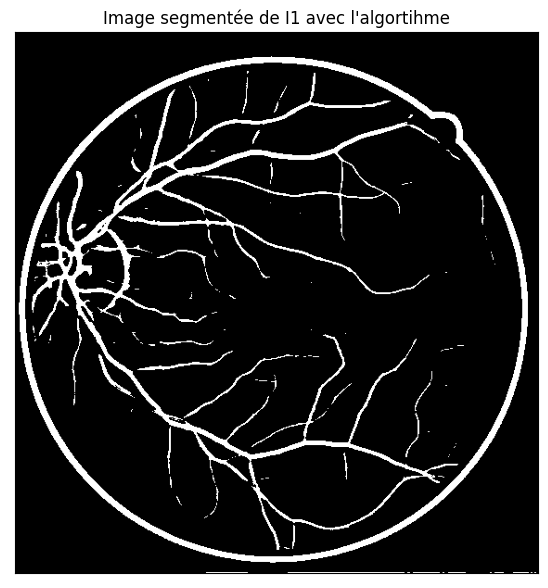

In [30]:
I1_vaisseau = msld.segment_vessels(I1.image, threshold)

data = [PlotData(title="Image segmentée de I1 avec l'algortihme", image=I1_vaisseau)]

plot_images(data);

**Q2.**  Vous devriez voir apparaître des erreurs de segmentations aux bords du fond d’oeil (à la frontière circulaire entre le fond d'oeil et le fond noir). À quoi est dû ce phénomène?



En inversant le canal vert de notre image, le fond noir autour de l'image de l'oeil est devenu très intense. Ainsi, lorsque le masque de notre algorithme passe sur ces régions, il interprête la grande variation d'intensité entre le fond de l'oeil, d'intensité faible sur l'image inversé, et le fond de l'image comme la présence d'un vaisseau sanguin.

**Q3.** Pour palier à ce problème, dupliquez les datasets, érodez la région d'intérêt (le masque) de manière à réduire le diamètre de 10 pixels, puis effectuez l'apprentissage du seuil à nouveau. Comparez les valeurs de seuil et la précision globale.



In [10]:
# Duplique les dataset
train_eroded = deepcopy(train)
test_eroded = deepcopy(test)

for d in train_eroded:
    # Erosion
    d.mask = skmorph.binary_erosion(d.mask, skmorph.disk(5))

# Même opération pour test_eroded
for d in test_eroded:
    # Erosion
    d.mask = skmorph.binary_erosion(d.mask, skmorph.disk(5))

I1_eroded = train_eroded[0]

In [11]:
new_threshold, new_accuracy = learn_threshold(msld, train_eroded)

print(f"Le meilleur seuil est à {new_threshold:.4f} lorsque les masques érodés sont utilisés.")
print(f"La nouvelle précision associée est de {new_accuracy:.4f}.")

Le meilleur seuil est à 0.5645 lorsque les masques érodés sont utilisés.
La nouvelle précision associée est de 0.9338.


**Q4.** On vous donne la fonction `show_diff(msld, sample, threshold, ax)` qui affiche les faux positifs en rouge, les faux négatifs en bleu, les vrais positifs en blanc et les vrais négatifs en noirs. Avec cette fonction, affichez la différence entre la prédiction et le label sur l’image I1. Commentez le résultat.

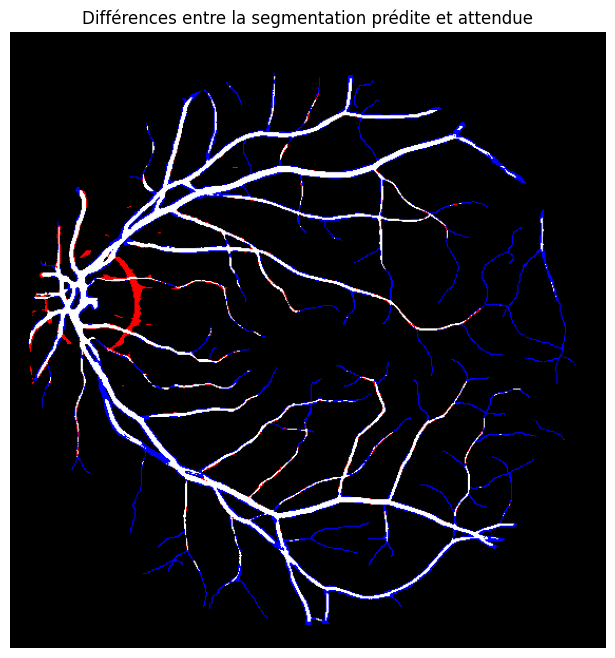

In [12]:
fig, ax = plt.subplots(1, 1)
show_diff(msld, I1_eroded, new_threshold, ax)


En observant les différences entre la segmentation obtenue avec notre algorithme et celle attendue, nous pouvons aussi observer que notre algorithme segmente à tord la frontière délimitant le nerf optique comme étant des vaisseaux sanguins. Cette erreur est dûe au fort contraste entre ces deux régions. De plus, nous pouvons aussi remarquer que notre algorithme ne parvient pas à segmenter correctement les extrémités du réseau vasculaire. Ce résultat provient de la combinaison du faible contraste dans ces régions et de l'utilisation d'un seuil pour filtrer le bruit. Ainsi, les extrémités des vaisseux sanguins sont perdues lors de notre segmentation, car elles sont considérées comme du bruit par notre algorithme.

# 2. Métriques de segmentation

## 2.1. Précision globale et locale

**Q1.** Implémentez la fonction `naive_metrics(msld, dataset, threshold)` qui évalue la précision et la matrice de confusion de l’algorithme pour un dataset donné. Puis calculez ces métriques sur l’ensemble de test.
*(N’oubliez pas de ne sélectionner que les pixels appartenant à la région d’intérêt!)*


In [13]:
accuracy, confusion_matrix = naive_metrics(msld, test_eroded, new_threshold) 

confusion_matrix_format = np.array([["TPR", "FNR"], ["FPR", "TNR"]])

print(f"La précision globale du modèle est de {accuracy:.4f}.")
print(f"La matrice de confusion du modèle est donnée ci-dessous : \n{confusion_matrix}\n\nLes données de cette matrice respectent le format suivant : \n{confusion_matrix_format}")

La précision globale du modèle est de 0.9382.
La matrice de confusion du modèle est donnée ci-dessous : 
[[0.86067254 0.05365012]
 [0.13932746 0.94634988]]

Les données de cette matrice respectent le format suivant : 
[['TPR' 'FNR']
 ['FPR' 'TNR']]


**Q2.** Utilisez la fonction `show_diff` pour afficher la prédiction sur `I1` à différents seuils et calculez la précision associée à chacun de ces seuils. Indiquez la valeur du seuil et la précision dans le titre de chaque carte de différence. Commentez sur l'effet du seuil.

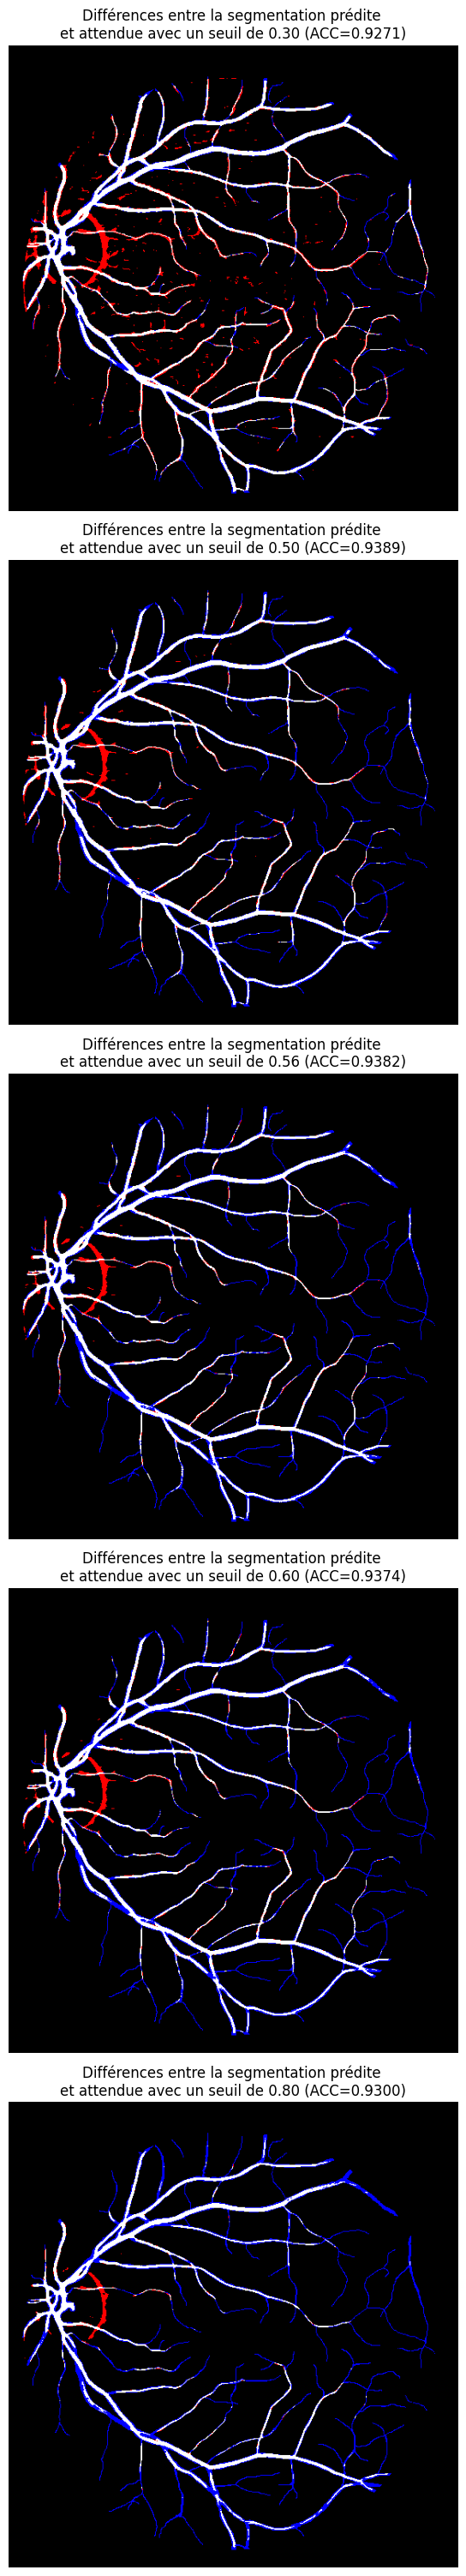

In [ ]:
seuils = [0.3, 0.5, new_threshold, 0.6, 0.8] 

fig, axes = plt.subplots(5,1, figsize=(32,30))
fig.tight_layout(h_pad=2.0)

for seuil, ax in zip(seuils, axes):

    accuracy, _ = naive_metrics(msld, test_eroded, seuil)

    show_diff(msld, I1_eroded, seuil, ax)
    ax.set_title(f"Différences entre la segmentation prédite \net attendue avec un seuil de {seuil:.2f} (ACC={accuracy:.4f})")

Il ne semble pas y avoir une variation significative de la précision en fonction du seuil de manière numérique. En effet, toutes les valeurs de précision obtenues sont comprises entre 92,71 et 93,89%. Cependant, visuellement on peut observer une diminutions des faux positifs (rouge) et une augmentation des faux négatfs (bleu) avec l'augmentation du seuil. Ce résultat est logique, car plus le seuil augmente, plus le bruit résiduel est classé correctement par le modèle comme un pixel de fond, mais les extrémités de faible intensités des vaisseaux sont perdues dans la segmentation.

**Q3.** Les auteurs proposent une seconde métrique: la précision locale. Quelles raisons avancent-ils
pour motiver cette proposition?


Puisque les pixel de fond occupent plus de 80% des images d'une rétine normale, la précision globale de tous les modèles utilisés est très haute. Ainsi, il est plus difficile de comparer les modèles entre eux. En calculant la précision sur une région obtenue en dilatant le label utilisé avec un élément structurant de taille 3, le nombre de pixels de fond approche le nombre de pixels de vaisseau. Ainsi, la précision locale donne une meilleure idée de la performance du modèle. De plus, selon les hypothèses des auteurs, le modèle proposé est sensé avoir une meilleure précision pour la segmentation des vaisseaux aux embranchements et lorsque deux vaisseaux sont très près l'un de l'autre. Ainsi, l'utilisation de la précision locale permet de mieux démontrer cette hypothèse de recherche.

**Q4.** Grâce à une opération morphologique, créez une copie du dataset ``test`` tel que son attribut mask corresponde à la région d’intérêt "locale" proposée par les auteurs. Puis, sans modifier la fonction `naive_metrics(msld, dataset, threshold)`, calculez la précision et la matrice de confusion locale.


In [15]:
test_local = deepcopy(test)

for d in test_local:
    # Dilatation du label pour former le masque
    d.mask = skmorph.binary_dilation(d.label, skmorph.disk(3))

In [ ]:
local_accuracy, local_confusion_matrix = naive_metrics(msld, test_local, new_threshold)

print(f"La précision locale du modèle est de {local_accuracy:.4f} lorsque l'élément structurant utilisé dans la dilatation du label est un cercle de rayon 3.")
print(f"La matrice de confusion du modèle est donnée ci-dessous : \n{local_confusion_matrix}\n\nLes données de cette matrice respectent le format suivant : \n{confusion_matrix_format}")

La précision locale du modèle est de 82.98% lorsque l'élément structurant utilisé dans la dilatation du label est un cercle de rayon 3.
La matrice de confusion du modèle est donnée ci-dessous : 
[[0.87709459 0.18648062]
 [0.12290541 0.81351938]]

Les données de cette matrice respectent le format suivant : 
[['TPR' 'FNR']
 ['FPR' 'TNR']]


**Q5.** Cette seconde métrique met plus en valeur l’algorithme proposé que la précision globale. Au vu des erreurs de l’algorithme révélées à la question 4 de l'exercice I.5, donnez une raison supplémentaire (omise par les auteurs) qui explique ce phénomène. 

L'algorithme utilisé effectue une mauvaise segmentation des pixels autour du disque optique, puisqu'il interprète la forte variation de contraste entre le fond de l'oeil et le disque optique comme la présence d'un vaisseau sanguin. Or, cette région est négligée lors du calcul de précision locale. Ainsi, cette métrique met plus en valeur l'algorithme proposé, puisqu'il masque les effets de ce défault.

## 2.2. Indice Dice (bonus)
De nombreux indices existent pour mieux évaluer les performances de segmentation que la précision globale: précision balancée, indice de Jaccard, kappa de Cohen, etc. Nous allons ici utiliser l'indice Sørensen-Dice. En notant $Y$ les labels et $\hat{Y}$ les prédictions de l'algorithme, l'indice Dice est défini par
$$\text{Dice}(Y, \hat{Y}) = 2\dfrac{Y \cap \hat{Y}}{Y + \hat{Y}}.$$

**Q1.** En quoi cette métrique répond aux limitations de la précision globale?

Le calcul de l'indice Dice n'utilise pas l'image complète, mais seulement les labels et les prédictions de l'algorithme. Ainsi, seuls très peu de pixels de fonds sont considérés dans le calcul de cette métrique, ce qui donne aux indices obtenues une plus grande valeur statistique.

**Q2.** Implémentez la fonction `dice(msld, dataset, threshold)` et calculez sa valeur sur la région d’intérêt globale et locale sur l’ensemble de test.


In [17]:
indice_global = dice(msld, test_eroded, new_threshold)
indice_local = dice(msld, test_local, new_threshold)

print(f"L'indice de dice est de {indice_global:.4f} lorsque l'on considère la région d'intérêt globale, alors qu'il est de {indice_local:.4f} lorsque l'on considère la région locale.")

L'indice de dice est de 0.5817 lorsque l'on considère la région d'intérêt globale, alors qu'il est de 0.5817 lorsque l'on considère la région locale.


Tel qu'attendu, l'indice de Dice est indépendant du masque utilisé, puisqu'il considère seulement les labels et les prédictions du modèle.

## 2.3. Courbe ROC et aire sous la courbe


Le choix d’un seuil de segmentation revient à faire un compromis entre faux-positifs et faux-négatifs (un seuil élevé limitera les faux-positifs mais augmentera les faux-négatifs et inversement). Le choix du bon compromis dépend bien souvent de l’application. Cependant les algorithmes se distinguent par le choix des caractéristiques à seuiller (ici un filtre MSLD) plutôt que par la méthode de sélection du seuil... [La courbe ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic##Area_under_the_curve) permet de représenter les performances de l’algorithme indépendamment du seuil choisi.   

Pour construire cette courbe, on calcule le taux de faux-positifs (FPR) et le taux de vrais-positifs (TPR=1−FNR) pour chaque valeur de seuil. La courbe obtenue (FPR en abscisse, TPR en ordonnée) caractérise l’efficacité de l’algorithme à distinguer les vaisseaux du fond, indépendamment du seuil.

Enfin, pour simplifier la comparaison entre deux courbes ROC, on extrait leurs [aires sous la courbe (AUC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic##Area_under_the_curve).

**Q1.** Que signifie une AUC de 1, de 0,5 ou de 0 pour les performances du modèle?


Si l'aire sous la courbe de ROC est égale à 1, cela signifie qu'il existe une séparation parfaite entre les deux groupes, tel que tous les positifs peuvent être correctement identifiés avec un seuil. À l'inverse, une aire sous la courbe de 0 signifie que les deux groupes sont séparés, mais cette-fois ci ce sont les négatifs qui sont identifiables avec le seuil et il faut prendre l'inverse de la prédiction pour trouver les positifs. Si l'aire sous la courbe est de 0,5, alors il n'y a pas de distinction claire entre les deux distributions et on ne peux alors obtenir une précision satisfaisante avec un tel modèle.

**Q2.**  Implémentez la fonction `plot_roc(msld, dataset, ax)` qui trace la courbe ROC et calcule son AUC. Puis faites de même pour la région d’intérêt globale et pour la région d’intérêt locale. Comparez les résultats et commentez.

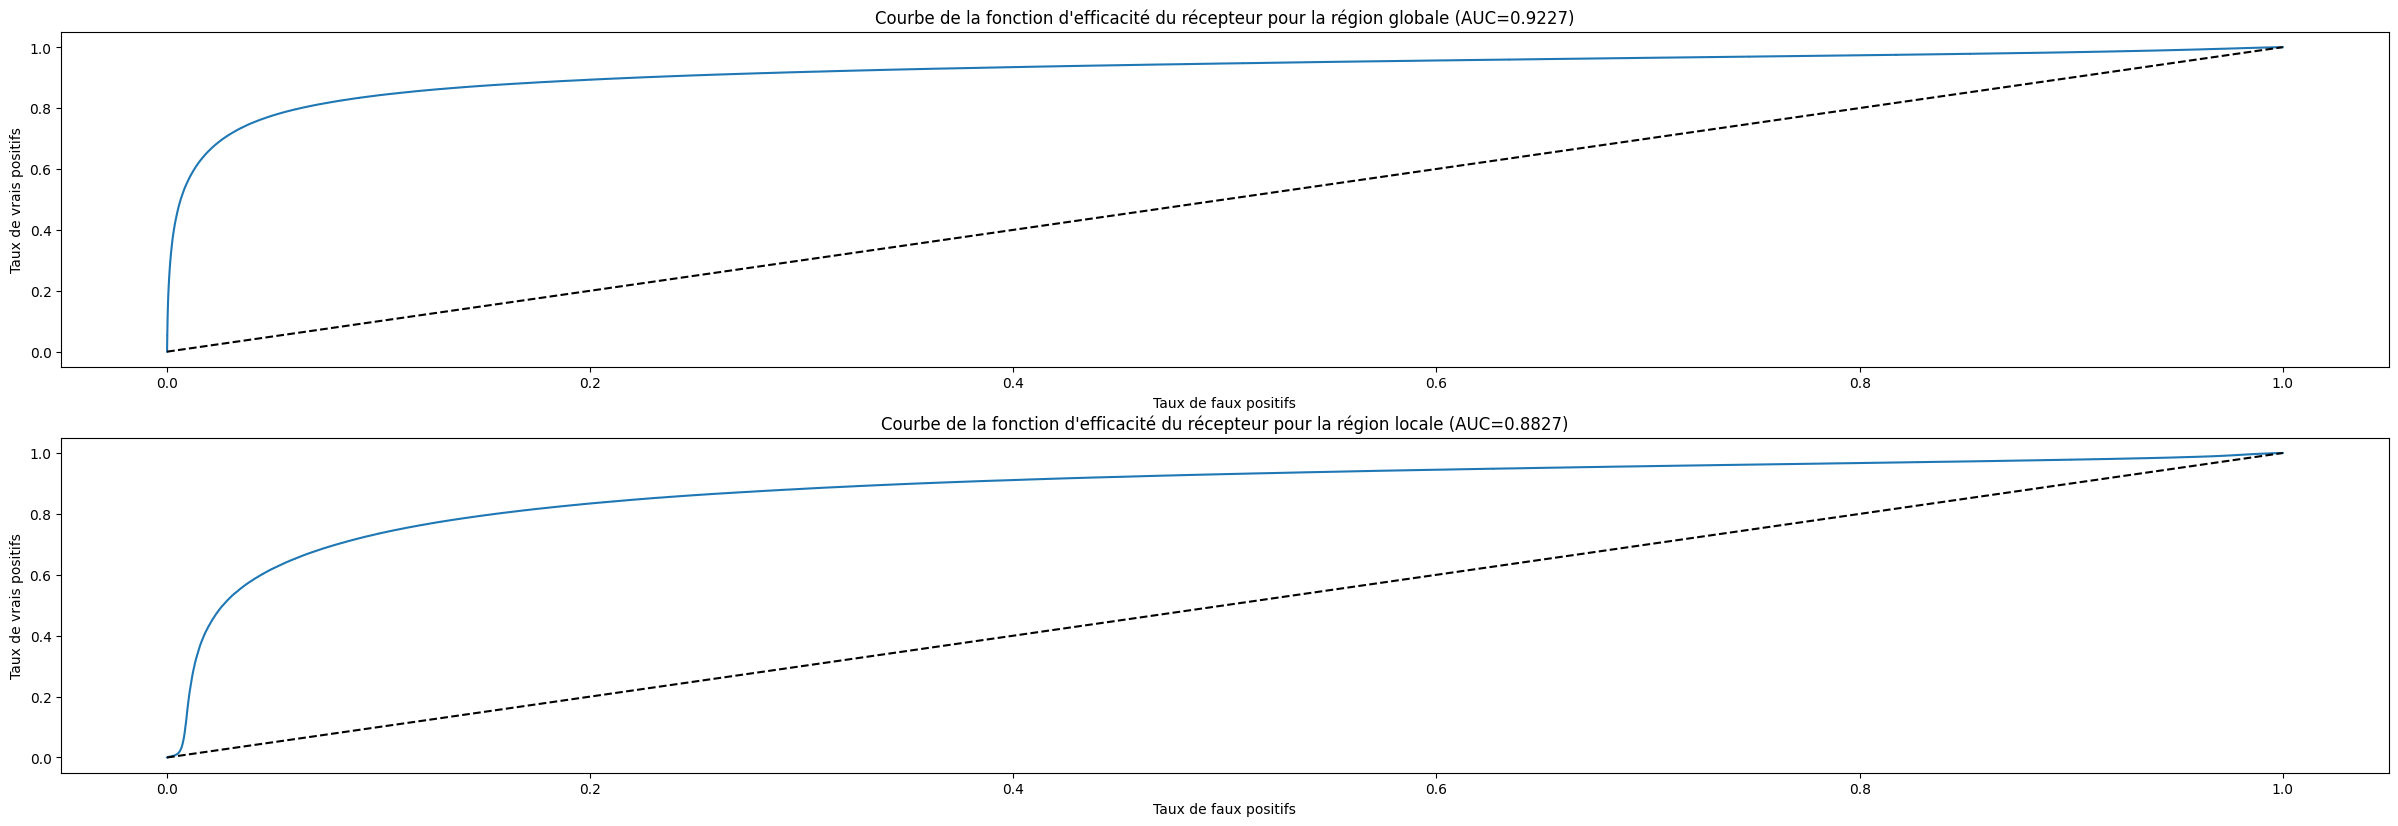

In [76]:
fig, axes = plt.subplots(2, 1, figsize=(24, 8))
fig.tight_layout(h_pad=3)

auc_global = plot_roc(msld, test_eroded, axes[0])
axes[0].set_title(f"Courbe de la fonction d'efficacité du récepteur pour la région globale (AUC={auc_global:.4f})")

auc_local = plot_roc(msld, test_local, axes[1])
axes[1].set_title(f"Courbe de la fonction d'efficacité du récepteur pour la région locale (AUC={auc_local:.4f})");

En analysant les valeurs des aires sous la courbe des deux fonctions, nous pouvons remarquer qu'elles sont très élevées. Cela démontre qu'il existe une bonne séparation dans la distribution des intensités entre les pixels de fond et les pixels des vaisseaux. En comparant les deux courbes, nous pouvons aussi remarque que la ROC pour la région globale possède un maximum plus éloigné de la ligne de centre que celui pour la région locale. Cela signifie qu'il existe une plus grande différence entre les distributions des pixels de fond et des pixels des vaisseaux lorsque l'ensemble de l'oeil est considéré. Ce résultat est logique, car les régions de fond difficiles à segmenter sont celles situés près des vaisseaux. Ainsi, la distinction entre les deux groupes paraît plus forte lorsque ces régions sont dillués par les autres régions de fond considéré dans la région globale.

# 3. Validation de l’hypothèse de recherche de l’article

À l’aide de votre implémentation de l’algorithme et des différents cas du dataset de test, discutez de la qualité du protocole expérimental pour vérifier les hypothèses de recherche sous-jacentes de l’article (telles que vous les aviez formulé dans le devoir 2).

Les hypothèses de recherche de l'article sont listées ci-dessous, suivies de notre analyse sur la qualité du protocole expérimental pour les vérifier.
1. *La méthode permet une segmentation plus exacte des régions autour des vaisseaux.* Le protocole utilisé démontre bien l'efficacité de la segmentation dans les régions autour des vaisseaux. Cela est reflété par la haute précision locale obtenue avec l'algorithme développé. Celle-ci est de 0.8298 en utilisant notre base de donné, ce qui est même plus élevé  que ce qu'ils ont obtenu dans l'article (0.7883 pour la banque DRIVE and 0.7630 for STARE)
2. *C’est une méthode qui ne requiert pas de segmentation manuelle des vaisseaux pour l'entraînement et dont la performance finale ne dépend pas de l’ensemble d’entraînement utilisé.* Il est vrai que la segmentation des images ne nécessite pas une annotation préalable de ces dernières pour délimiter les vaisseaux. L'entrainement s'est fait avec les images d'origine directement. Cela garantit une robustesse accrue face à la variabilité des données, car il n’est pas biaisé par un ensemble d’entraînement particulier. Par contre, l'apprentissage du seuil nécessite de comparer la segmentation prédite au label des images utilisés. Ainsi, comme l'utilité de l'algorithme développé dans l'article diminue de beaucoup sans l'établissement de ce seuil, le protocole expérimental proposé ne démontre pas que la méthode est complètement indépendante de la segmentation manuelle des vaisseaux.
3. *C’est une méthode efficace et rapide.* Le temps de segmentation de notre algorithme est très rapide, soit de 1,1 secondes. De plus, comme le modèle complet n'a besoin d'ajuster qu'un seul paramètre (le seuil), l'apprentissage du modèle se fait très rapidement.
4. *C’est une méthode qui peut être appliquée sur des images de haute résolution.* L'algorithme est facilement adaptable à des images de haute résolution en augmentant la valeur de W. Par contre, comme la complexité algorithmique de la convolution est très grande, le temps de segmentation de l'image risque d'évoluer de manière nonlinéaire avec la résolution des images utilisées.


# 4. Discussion



**Q1.** Discutez du choix des hyper-paramètres `W`, `L` (nombre d’échelles et répartition) et `num_orientations`. Leurs valeurs ont-elles des justifications théoriques? Quels sont leur impact en pratique?

W représente la taille de la fenêtre d'observation autour d'un pixel. Cette taille est choisie pour inclure un nombre à peu près égal de pixels de vaisseau et de fond. Elle est généralement fixée à environ deux fois la largeur typique des vaisseaux dans les images. Le code suivant démontre l'impact de cet hyperparamètre sur la segmentation.

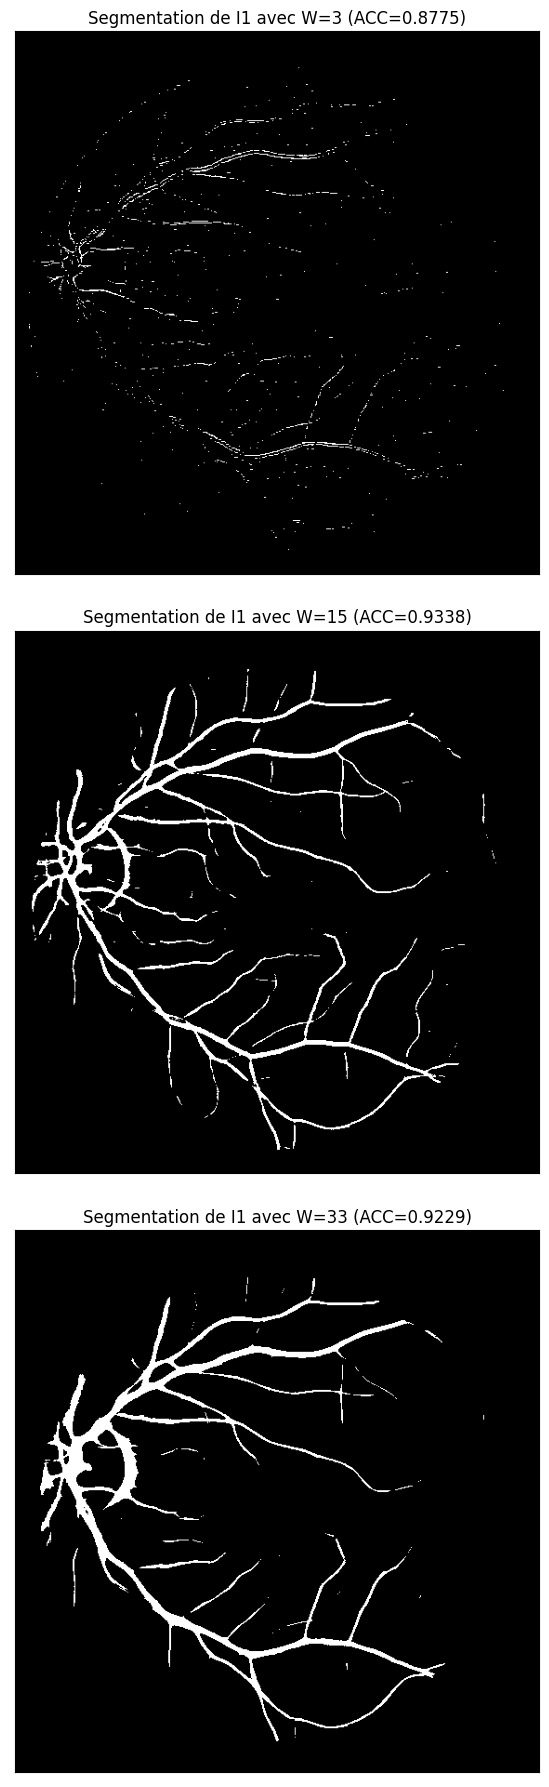

In [33]:
msld_narrow_W = MultiScaleLineDetector(3, [1, 3], 12)
msld_wide_W = MultiScaleLineDetector(33, [1, 5, 9, 13, 17, 21, 25, 29, 33], 12)

narrow_threshold, narrow_accuracy = learn_threshold(msld_narrow_W, train_eroded)
wide_threshold, wide_accuracy = learn_threshold(msld_wide_W, train_eroded)

data = [PlotData(title=f"Segmentation de I1 avec W=3 (ACC={narrow_accuracy:.4f})", image=msld_narrow_W.segment_vessels(I1_eroded.image, narrow_threshold) * I1_eroded.mask),
        PlotData(title=f"Segmentation de I1 avec W=15 (ACC={new_accuracy:.4f})", image=msld.segment_vessels(I1_eroded.image, new_threshold) * I1_eroded.mask),
        PlotData(title=f"Segmentation de I1 avec W=33 (ACC={wide_accuracy:.4f})", image=msld_wide_W.segment_vessels(I1_eroded.image, wide_threshold) * I1_eroded.mask)]

plot_images(data);

En comparant ces trois images, nous pouvons voir que lorsque la largeur de la fenêtre est inférieur au diamètre d'un vaisseau, ce dernier est simplement effacer par l'algorithme. En effet, comme seuls des pixels de vaisseaux sont compris dans la fenêtre, alors le Basic Line Detector ne perçoit pas de différence entre l'intensité des pixels moyennes et ceux d'une des lignes principales. Ainsi, la segmentation obtenue est très mauvaise. De plus, lorsque la largeur de la fenêtre est trop grande, le filtre MSLD agit comme un filtre gradient et dillue les contours des vaisseaux segmentatés. Plusieurs détails fins sont ainsi perdus.

L représente la longueur des lignes utilisées dans les Basic Line Detetors. Celle-ci doit se situer entre 1 et W. En modifiant cette longueur, nous obtienons des détecteurs de lignes à différentes échelles. Des lignes courtes évitent d'inclure des pixels de vaisseaux voisins, ce qui permet de mieux segmenter des situations complexes. Les lignes longues permettent de réduire l'impact du bruit dans l'image moyenne. Le code suivant permet de mieux démontrer ces effets.


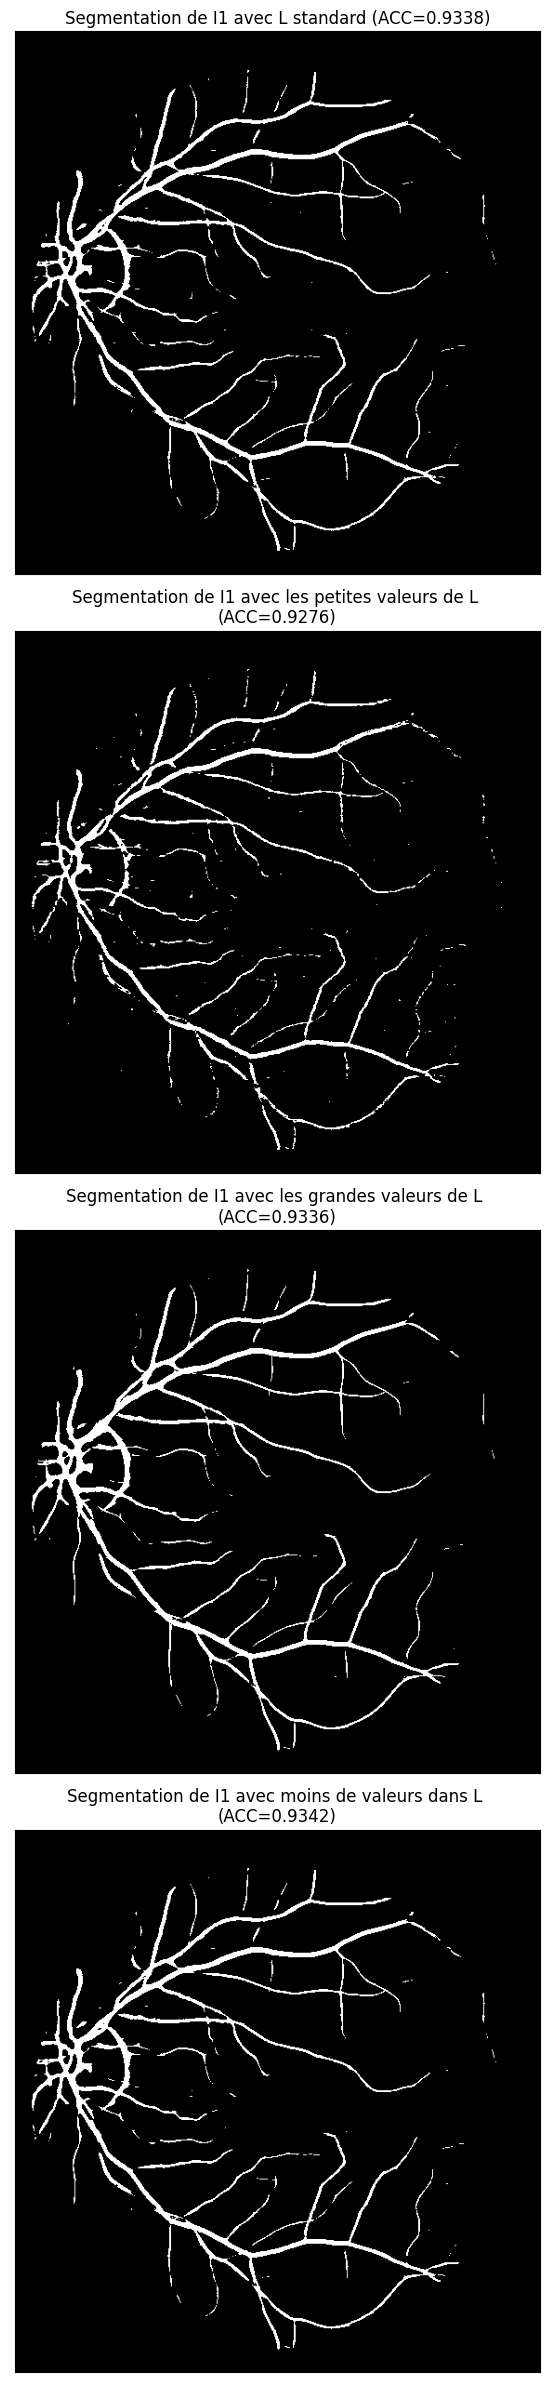

In [34]:
msld_lower_end_L = MultiScaleLineDetector(15, [1, 3, 5], 12)
msld_higher_end_L = MultiScaleLineDetector(15, [11, 13, 15], 12)
msld_sparser_L = MultiScaleLineDetector(15, [3, 7, 11, 15], 12)

lower_end_threshold, lower_end_accuracy = learn_threshold(msld_lower_end_L, train_eroded)
higher_end_threshold, higher_end_accuracy = learn_threshold(msld_higher_end_L, train_eroded)
sparser_threshold, sparser_accuracy = learn_threshold(msld_sparser_L, train_eroded)

data = [PlotData(title=f"Segmentation de I1 avec L standard (ACC={new_accuracy:.4f})", image=msld.segment_vessels(I1_eroded.image, new_threshold) * I1_eroded.mask),
        PlotData(title=f"Segmentation de I1 avec les petites valeurs de L \n(ACC={lower_end_accuracy:.4f})", image=msld_lower_end_L.segment_vessels(I1_eroded.image, lower_end_threshold) * I1_eroded.mask),
        PlotData(title=f"Segmentation de I1 avec les grandes valeurs de L \n(ACC={higher_end_accuracy:.4f})", image=msld_higher_end_L.segment_vessels(I1_eroded.image, higher_end_threshold) * I1_eroded.mask),
        PlotData(title=f"Segmentation de I1 avec moins de valeurs dans L \n(ACC={sparser_accuracy:.4f})", image=msld_sparser_L.segment_vessels(I1_eroded.image, sparser_threshold) * I1_eroded.mask)]

plot_images(data);

En comparant ces images, nous remarquons effectivement que la segmentation générée avec de petites valeurs de L possède beaucoup plus de bruit que celle de référence et que plusieurs vaisseaux se sont fusionner dans la segmentation générée avec de grandes valeurs de L. De plus, en analysant la segmentation générée avec des valeurs de L plus distancées, on remarque que cette dernière est légèrement moins bien défini, mais possède un temps de calcul nettement inférieur. Ainsi, si le temps de segmentation devient un enjeu, nous pouvons espacer davantage la distribution des longueurs de ligne sans perdre beaucoup d'information. 

Finalement, num_orientation représente le nombre d'oritentations auxquelles sont alignées les lignes dans le basic line detector. Ce nombre est choisi en fonction de la taille de la fenêtre d'observation afin de couvrir une bonne espace à l'intérieur de la fenêtre. Le code suivant permet de démontrer les effets de cet hyperparamètre sur la segmentation. 

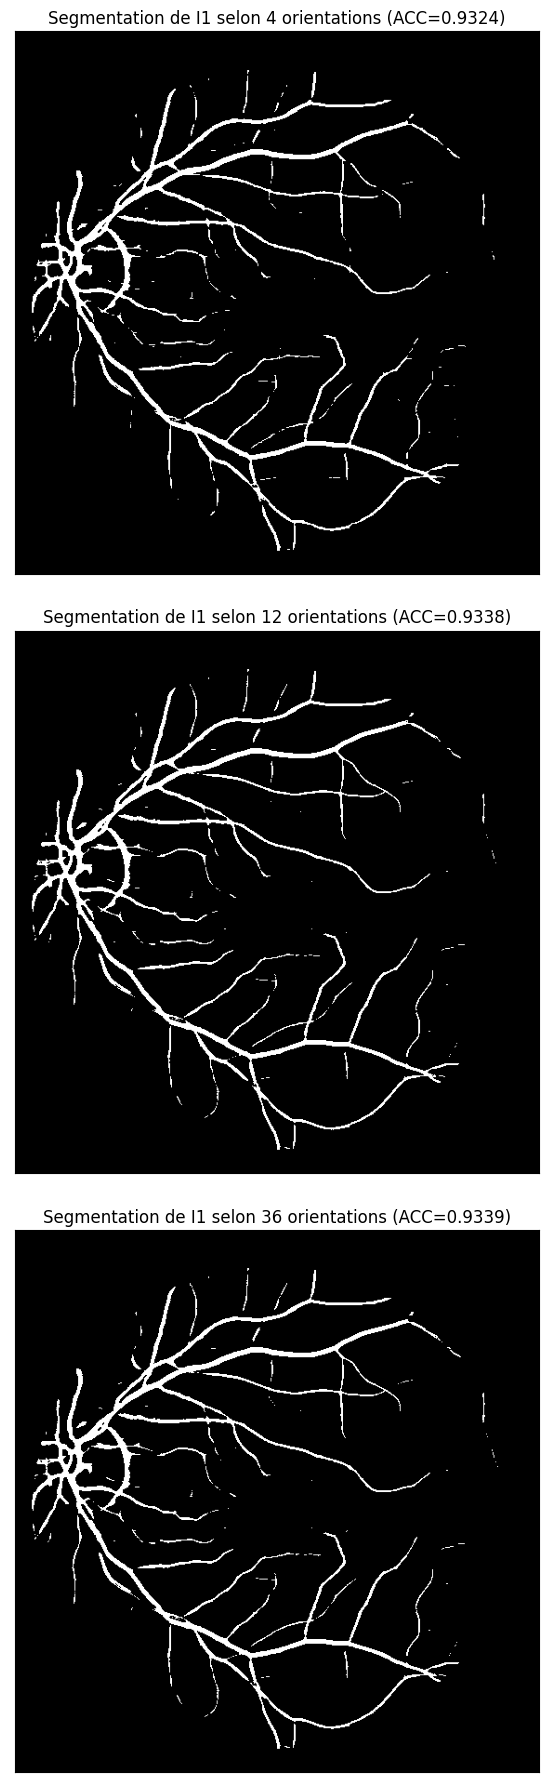

In [35]:
msld_less_ori = MultiScaleLineDetector(15, [1, 3, 5, 7, 9, 11, 13, 15], 4)
msld_more_ori = MultiScaleLineDetector(15, [1, 3, 5, 7, 9, 11, 13, 15], 36)

less_ori_threshold, less_ori_accuracy = learn_threshold(msld_less_ori, train_eroded)
more_ori_threshold, more_ori_accuracy = learn_threshold(msld_more_ori, train_eroded)

data = [PlotData(title=f"Segmentation de I1 selon 4 orientations (ACC={less_ori_accuracy:.4f})", image=msld_less_ori.segment_vessels(I1_eroded.image, less_ori_threshold) * I1_eroded.mask),
        PlotData(title=f"Segmentation de I1 selon 12 orientations (ACC={new_accuracy:.4f})", image=msld.segment_vessels(I1_eroded.image, new_threshold) * I1_eroded.mask),
        PlotData(title=f"Segmentation de I1 selon 36 orientations (ACC={more_ori_accuracy:.4f})", image=msld_more_ori.segment_vessels(I1_eroded.image, more_ori_threshold) * I1_eroded.mask)]

plot_images(data);

En comparant ces images, nous pouvons aussi remarquer que la segmentation des vaisseaux sanguins est meilleure lorsque leur orientation est proche d'une des orientations de référence utilisé. Ainsi, la segmentation avec 4 orientations est correcte pour les vaisseaux horizontaux, verticaux et diagonaux, mais est mauvaise dans les autres directions. De plus, comme les 12 orientations du modèle de référence couvre suffisament bien l'espace défini par une fenêtre de largeur 15x15, il n'existe que très peu de différence entre cette segmentation et celle du modèle avec 36 orientations. Ces orientations supplémentaires sont donc superflues et alourdissent la segmentation de l'image.

**Q2.** Les auteurs ont choisi le seuil donnant la meilleure précision sur l’ensemble d’entraînement. Connaissant les analyses effectuées dans la partie 2, discutez de ce choix.

La précision elle-même n'est pas la meilleure métrique pour évaluer l'efficacité d'un modèle. Tel que discuté dans la partie 2, elle est très sensible au ratio entre le nombre de pixels des deux groupes. Comme 80% des pixels d'une image de rétine moyenne sont des pixels de fond, les auteurs auraient pu effectuer leur ajustement en utilisant une métrique plus robuste, tel que l'indice de Dice défini dans la section 2.3. Par ailleurs, le modèle dont le seuil possède la meilleure précision n'est pas nécessairement celui qui offre la segmentation la plus utile. En effet, le choix du seuil par optimisation de la précision revient à trouver la configuration qui minimise le nombre de faux positif et de faux négatif dans l'image. De plus, tel que démontrer à la question 2 de la section 2.1, il existe une plage de valeurs de seuil pour lesquelles la précision du modèle varie peu. Or, l'impact d'un faux positif ou d'un faux négatif peut varier selon application de notre segmentation. Par exemple, si l'objectif de notre segmentation est de guidé un robot-chirurgien afin qu'il évite les vaisseaux sanguins lors d'une opération, il peut s'avérer plus important de minimiser le nombre de faux négatif que de maximiser la précision du modèle. 

**Q3.** En vous appuyant sur vos expérimentations pour les deux dernières parties de cet énoncé, proposez des recommandations pour améliorer l’algorithme.

Tel que mentionné plus haut, l'algorithme proposé effectue une mauvaise segmentation des vaisseaux près du nerf optique. Ainsi, le modèle pourrait inclure un algorithme de segmentation du disque et exclure certains pixels au contour du disque trouver selon s'ils ne respectent pas un prédicat fourni. Le code ci-contre implémente un tel algorithme et l'ajoute à la segmentation effectuée par la technique du MSLD.

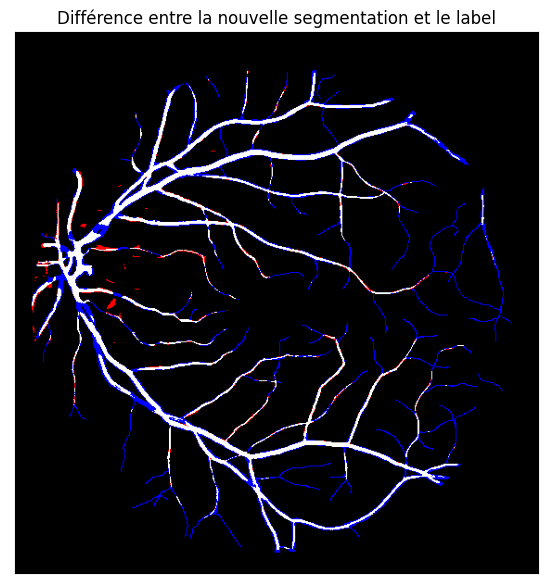

In [ ]:
from math import ceil, pi
from scipy.ndimage import convolve
from skimage.draw import circle_perimeter

def binariser(img: np.ndarray, seuil: float) -> np.ndarray:
    img_binaire = np.where(img >= seuil, 1, 0)
    return img_binaire

def generate_circle_mask(radius: int, center: tuple[int, int] | None = None, size: tuple[int, int] | None = None) -> np.ndarray:
    mask = np.zeros((2 * radius + 1, 2 * radius + 1), dtype=np.uint8)

    if center is None:
        rr, cc = circle_perimeter(radius, radius, radius)
    else:
        rr, cc = circle_perimeter(radius, center[0], center[1])
    mask[rr, cc] = 1.0

    return mask

Wgaussienne7 = (
    np.array(
        [
            [1, 4, 7, 10, 7, 4, 1],
            [4, 12, 26, 33, 26, 12, 4],
            [7, 26, 55, 71, 55, 26, 7],
            [10, 33, 71, 91, 71, 33, 10],
            [7, 26, 55, 71, 55, 26, 7],
            [4, 12, 26, 33, 26, 12, 4],
            [1, 4, 7, 10, 7, 4, 1],
        ]
    )
    / 1115
)

min_radius = ceil(min(I1.image.shape[0]/15, I1.image.shape[1]/15))
max_radius = ceil(min(I1.image.shape[0]/6.67, I1.image.shape[1]/6.67))
circle_radii = np.linspace(min_radius, max_radius, (max_radius - min_radius)//5)
circle_masks = [generate_circle_mask(ceil(circle_radius)) for circle_radius in circle_radii]

seuil_binarisation = 0.60
seuil_hough = 0.1275
seuil_normalisation = 0.50
opening_radius = 2

I1_vert = I1.image[:, :, 1] # Isolation du canal vert de l'image
I1_vert_binarise = binariser(I1_vert, seuil_binarisation) # Binarisation de l'image

# Ouverture morphologique afin de réduire le bruit
ouverture_I1_vert_b = skmorph.binary_opening(I1_vert_binarise, skmorph.disk(opening_radius)) 

# Création d'un contour précis en prenant le résultat de la dilatation par un disque de rayon 1
contour_I1 = (skmorph.binary_dilation(ouverture_I1_vert_b, skmorph.disk(1)) ^ ouverture_I1_vert_b).astype(float)

# Utilisation de la transformée de Hough afin de détecter le contour du nerf optique, qui est considérer comme un cercle.
hough_transform_matrix = np.array([convolve(contour_I1, mask, mode='constant')/np.sum(mask) for mask in circle_masks])

# Reconstruction du nerf optique à partir de la matrice de Hough. Seuls les maximums locaux sont gardés pour la reconstruction du disque
ceiled_hough_matrix = binariser(hough_transform_matrix, seuil_hough)
disk_segmentation = sum([convolve(hough_submatrix, mask, mode='constant') for hough_submatrix, mask in zip(ceiled_hough_matrix, circle_masks)])

# Normalisation et binarisation du disque optenu
normalized_disk_segmentation = disk_segmentation/np.max(disk_segmentation)
disk_segmentation_binarise = binariser(normalized_disk_segmentation, seuil_normalisation)

# Épaississement du contour obtenu par dilatation morphologique avec un disque de rayon 5
final_disk_segmentation = skmorph.binary_dilation(disk_segmentation_binarise, skmorph.disk(5))

# Création de la nouvelle segmentation
I1_vaisseau = msld.segment_vessels(I1.image, new_threshold)
I1_new_vaisseau = I1_vaisseau & ~final_disk_segmentation

# Affichage des résultats
pred = I1_new_vaisseau & I1_eroded.mask
label = I1_eroded.label & I1_eroded.mask

red = pred.astype(float)
blue = label.astype(float)
green = (pred & label).astype(float)

rgb = np.stack([red, green, blue], axis=2)

plot_images([PlotData(title="Différence entre la nouvelle segmentation et le label", image=rgb)]);


### Fonctions de visulisation des différentes étapes (utiliser lors de l'élaboration de l'algorithme)
# plot_images([PlotData(title=f"Image binarisée avec un seuil {seuil}", image=I1_vert_binarise * I1_eroded.mask)]);
# plot_images([PlotData(title=f"Ouverture de l'image binarisée avec un disque de rayon {opening_radius}", image=ouverture_I1_vert_b * I1_eroded.mask)]);
# plot_images([PlotData(title="Contour de l'image binarisée après ouverture", image=contour_I1 * I1_eroded.mask)]);
# data = [PlotData(title=f"Masque {index}", image=mask) for index, mask in enumerate(circle_masks)]
# plot_images(data);
# data = [PlotData(title=f"Transformée de Hough normalisée de rayon {radius}", image=hough_map) for radius, hough_map in zip(circle_radii, ceiled_hough_matrix)]
# plot_images(data);
# plot_images([PlotData(title="Segmentation du disque optique normalisée", image=normalized_disk_segmentation)]);
# plot_images([PlotData(title="Segmentation du disque optique binarisée", image=disk_segmentation_binarise)]);
# plot_images([PlotData(title="Nouvelle segmentation des vaisseaux sanguins", image=I1_new_vaisseau * I1_eroded.mask)]);

En comparant la segmentation obtenue, nous pouvons remarqué que l'erreur de segmentation du disque optique est nettement améliorer. Par contre, notre algorithme coupe aussi les vaisseaux sanguins qui passe sur le contour du nerf optique. Ainsi, notre algorithme pourrait être améliorer en faisant un meilleur ajustement des hyperparamètres et en complexifiant le prédicat utilisé lors de la comparaison des régions morphologiques générées par la segmentation des vaisseaux et celle du disque optique.